# TelFit head-to-head (*paused*)
### Multi-layer atmosphere with $H_2 O$, $CO_2$, and $O_2$
### Using HITRAN, `jax`, and NVIDIA GPUs

A stalled attempt to match the atmosphere profile exactly so we can scrutinize differences.  
Do any atmospheric scientists want to weigh in?

May 2020

In [1]:
import astropy.units as u
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import hapi
hapi.db_begin('../../hapi/data/')

from jax.config import config
config.update("jax_enable_x64", False)

import jax.numpy as np
from jax import vmap, jit, grad, random
from jax.lax import stop_gradient
from jax import jacfwd
from functools import partial

import pandas as pd

HAPI version: 1.1.0.9.7
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005
Using ../../hapi/data/

H2O
                     Lines parsed: 70039
CO2
                     Lines parsed: 69523
O2
                     Lines parsed: 679


In [2]:
! du -hs ../../hapi/data/*.data

11M	../../hapi/data/CO2.data
11M	../../hapi/data/H2O.data
108K	../../hapi/data/O2.data


In [3]:
@jit
def gamma_of_p_and_T(p, T, p_self, n_air, gamma_air_ref, gamma_self_ref):
    '''Compute the Lorentz HWHM with pressure and temp'''
    return (296.0/T)**n_air *(gamma_air_ref*(p-p_self) + gamma_self_ref*(p_self))

In [4]:
@jit
def lorentz_profile(nu, p, nu_ij, gamma, dp_ref, S_ij):
    '''Return the Lorentz line profile given vectors and parameters'''
    return S_ij/np.pi * gamma / ( gamma**2 + (nu - (nu_ij + dp_ref*p))**2)

In [5]:
@jit
def tips_Q_of_T(T, g_k, E_k):
    '''Total Internal Partition Sum'''
    c_2 = 1.4387770 #cm K
    return np.sum( g_k * np.exp(- c_2 * E_k / T) )

In [6]:
@jit
def S_ij_of_T(T, S_ij_296, nu_ij, g_lower, E_lower):
    '''The Spectral Line Intensity'''
    c_2 = 1.4387770 #cm K
    return (S_ij_296 * 
            stop_gradient(tips_Q_of_T(296.0, g_lower, E_lower)) / 
            tips_Q_of_T(T, g_lower, E_lower) *
            np.exp(-c_2 * E_lower/T) /np.exp(-c_2 * E_lower/296.0) *
           (1-np.exp(-c_2*nu_ij/T) )/(1-np.exp(-c_2*nu_ij/296.0)))

In [7]:
@jit
def transmission_of_T_p(T, p, nus, vol_mix_ratio, atomic_data):
    '''Return the absorption coefficient as a function of T'''
    
    (n_air, gamma_air, gamma_self, E_lower, g_lower,\
     nu_lines, delta_air, S_ij_296) = atomic_data
    
    gammas = vmap(gamma_of_p_and_T, in_axes=(None, None, None, 0, 0, 0)\
                                )(p, T,vol_mix_ratio, n_air, gamma_air, gamma_self)
    
    S_ij = S_ij_of_T(T, S_ij_296, nu_lines, g_lower, E_lower)
    
    abs_coeff = vmap(lorentz_profile, in_axes=(None, None, 0, 0,0, 0))(nus, p,
                                     nu_lines, gammas, delta_air, S_ij).sum(axis=0)
    #path_length_km = 1.0
    tau = abs_coeff * (vol_mix_ratio*2.688392857142857e+19) * (1.0*100000.0)
    return np.exp(-tau)

### Compute the transmission spectrum

Requires a path length.  Let's assume constant density of the Earth's atmosphere, and 3 km path length.

The HITRAN absorption coefficient $\alpha$ units are: $cm^{−1}/(molecule⋅cm^{−2})$

So we have the optical depth:

$$ \tau_{ij}(\nu, T, p) = \alpha \cdot n \cdot \ell$$

where $n$ is the number density of particles, and $\ell$ is the path length.

In [8]:
def get_hapi_molec_data(species):
    '''return the order columns in device arrays
    TODO: a bit fragile, consider returning a dict instead!
    '''
    ordered_cols = ['n_air','gamma_air','gamma_self','elower','gpp','nu','delta_air','sw']
    return [np.array(hapi.getColumn(species, col)) for col in ordered_cols]

In [9]:
#(n_air, gamma_air, gamma_self, E_lower, g_lower, nu_lines, delta_air, S_ij_296) = get_hapi_molec_data('H2O')

## Get the atmospheric profile from TDAS  
Follow the prescription from Kevin Gullikson:
https://telfit.readthedocs.io/en/latest/GDAS_atmosphere.html

For now we'll use the average composition profiles from [the same source as TelFit](http://eodg.atm.ox.ac.uk/RFM/atm/ngt.atm)

In [11]:
#! wget http://eodg.atm.ox.ac.uk/RFM/atm/ngt.atm
#! mv ngt.atm ../data/

In [24]:
pt_prof = pd.read_csv('../data/telfit_HRRR_PT_profile_20200514UTC.txt', skiprows=28, nrows=36, delim_whitespace=True,
           names=['PRESS','HGT(MSL)','TEMP','DEW PT','WND DIR','WND SPD'])
pt_prof['HGT(MSL)'] = pt_prof['HGT(MSL)'].str[:-2].astype(float)

HET is at about 2,026 meters, so truncate to the closest height.

Hmm the formula copied from the TelFit website for converting to RH from dewpoint seems wrong.  
Dew point does not enter into the equation at all...

In [25]:
Pw = 6.116441 * 10**(7.591386*pt_prof.TEMP/(pt_prof.TEMP + 240.7263))
pt_prof['H2O [ppmv]'] = Pw / (pt_prof.PRESS-Pw) * 1e6

In [26]:
pt_prof = pt_prof[5:].reset_index(drop=True)
pt_prof.head()

,PRESS,HGT(MSL),TEMP,DEW PT,WND DIR,WND SPD,H2O [ppmv]
0,794.0,2060.0,21.8,-8.9,264.4,10.5,34008.361891
1,781.0,2206.0,20.3,-9.3,264.9,10.6,31454.252624
2,763.0,2396.0,18.5,-9.6,265.7,10.9,28710.170796
3,746.0,2591.0,16.6,-9.9,266.7,10.8,25978.557334
4,728.0,2797.0,14.5,-10.3,268.1,10.7,23206.793064


In [15]:
cols = ['HGT [km]','PRE [mb]','TEM [K]','N2 [ppmv]','O2 [ppmv]','CO2 [ppmv]','O3 [ppmv]',
        'H2O [ppmv]','CH4 [ppmv]','N2O [ppmv]','HNO3 [ppmv]','CO [ppmv]','NO2 [ppmv]',
        'N2O5 [ppmv]','ClO [ppmv]','HOCl [ppmv]','ClONO2 [ppmv]','NO [ppmv]','HNO4 [ppmv]',
        'HCN [ppmv]','NH3 [ppmv]','F11 [ppmv]','F12 [ppmv]','F14 [ppmv]','F22 [ppmv]',
        'CCl4 [ppmv]','COF2 [ppmv]','H2O2 [ppmv]','C2H2 [ppmv]','C2H6 [ppmv]','OCS [ppmv]',
        'SO2 [ppmv]','SF6 [ppmv]']

ngt_atm = pd.read_csv('../data/ngt.atm', comment='*', delim_whitespace=True, skiprows=25, names='ABCDE')
ngt_atm = pd.DataFrame(data=ngt_atm.stack().values.reshape(33, 121)).T
ngt_atm.columns = cols

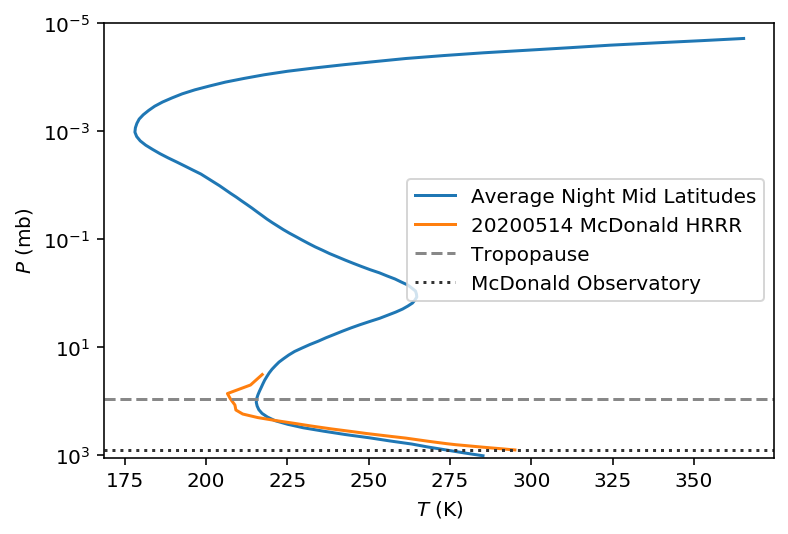

In [27]:
plt.plot(ngt_atm['TEM [K]'], ngt_atm['PRE [mb]'], label='Average Night Mid Latitudes')
plt.plot(pt_prof['TEMP']+273.15, pt_prof['PRESS'], label='20200514 McDonald HRRR')

plt.axhline(ngt_atm.loc[17, 'PRE [mb]'], linestyle='dashed', color='#888888', label='Tropopause')
plt.axhline(794, linestyle='dotted', color='#333333', label='McDonald Observatory')
plt.ylim(1100, 1e-5); plt.yscale('log'); plt.ylabel('$P$ (mb)'); plt.xlabel('$T$ (K)');
plt.legend();

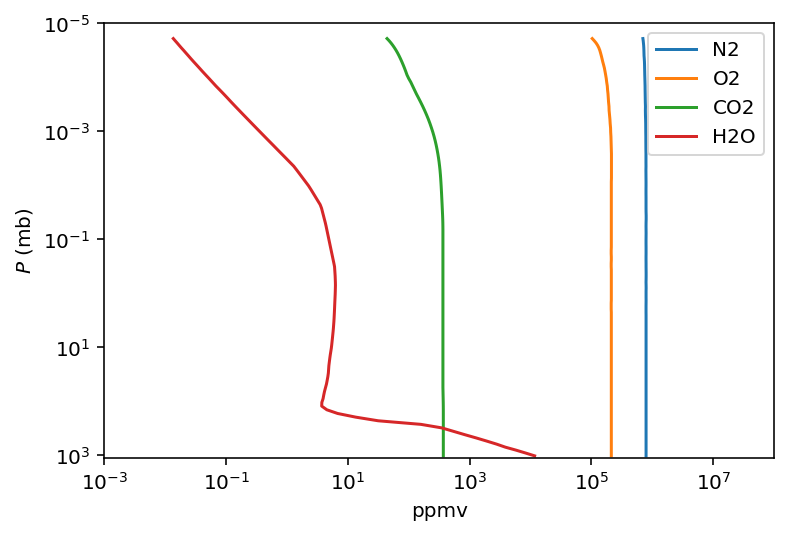

In [30]:
for species in ['N2', 'O2', 'CO2', 'H2O']:
    plt.plot(ngt_atm[species+' [ppmv]'], ngt_atm['PRE [mb]'], label=species)
    
#plt.plot(pt_prof['H2O [ppmv]'], pt_prof['PRESS'], label='20200514 Miscalculated! see note')
plt.ylim(1100, 1e-5); plt.yscale('log'); plt.ylabel('$P$ (mb)'); plt.xlabel('ppmv');
plt.xlim(1e-3, 1e8); plt.xscale('log'); plt.legend();

# Fail

We encountered problems here: 

#### 1) Get H2O ppmv from dew point  
We did not convert to ppmv correctly from dew point because the TelFit website equation seems incorrect.  The solution is to visit the obscure PDF website that Kevin Gullikson listed and track down the equations.

#### 2) GDAS unavailable, HRRR Atmosphere profile terminates near the tropopause  
Is it safe to assume that the stratosphere does not matter?  Or does not change much?

#### 3) We are only using Lorentzians
We could/should include Gaussians for the high temperature/low density regime.  We should technically convolve these profiles on a line-by-line basis.

# Success

#### 1) We *did* get TelFit to work in this notebook
It will be easy to compare head-to-head once we figure out the issues above!  (see below)

#### 2) We have the machinery to match to HPF resolution/sampling
We read in an example file so that we can match the wavelength sampling, bandwidth, and spectral resolution.

# General thoughts

#### 1) How to properly specify and perturb/infer atmosphere profile  
I think TelFit presently tweaks the entire atmosphere profile by a single scalar value, which seems inexact-- really you want to infer the concentration as a function of height, so a set of $N_{layers}$ scalars.  These scalars are connected in some way, and so maybe the right thing to do is to treat them as (shrinkage) prior means in a hierarchical framework, and infer revised values.  
Operationally, a head-to-head comparison should simply set the exact same P-T profile and not "tweak" the values as is done in a fit.  Simply, do we get the same input/output as TelFit?

## Run LBLRTM with TelFit, match to HPF resolution/sampling

In [14]:
from astropy.io import fits
from astropy.table import Table

In [15]:
hdus = fits.open('../../ucdwhpf/data/HPF/goldilocks/Goldilocks_20200507T100451_v1.0_0017.spectra.fits')

In [16]:
df_all = pd.DataFrame()
for m in range(28):
    tab = Table({hdus[i].name:hdus[i].data[m,:] for i in range(1,10)})
    tab['order'] = m
    df_all = df_all.append(tab.to_pandas(), ignore_index=True)

In [17]:
df_all.tail(1)

,Sci Flux,Sky Flux,Cal Flux,Sci Error,Sky Error,Cal Error,Sci Wavl,Sky Wavl,Cal Wavl,order
57343,0.0,0.0,0.0,0.0,0.0,0.0,12785.831225,12785.830446,12785.820246,27


In [18]:
lo, hi = df_all['Sci Wavl'].min(), df_all['Sci Wavl'].max()

In [19]:
nus = np.array((df_all['Sci Wavl'].values*u.Angstrom).to(1/u.cm, equivalencies=u.spectral()).value)

/home/gully/miniconda3/envs/fiatlux_CUDA10p2/lib/python3.7/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [20]:
nus.shape

(57344,)

In [22]:
%%capture
from telfit import Modeler
telfit_modeler = Modeler()

In [27]:
%%time
result = telfit_modeler.MakeModel(pressure=1005.0, temperature=273.15+14.0,
    lowfreq=nus.min(), highfreq=nus.max(), angle=0.0,humidity=20.0,
    lat=19.8, alt=2.0,resolution=55000.0,vac2air=False)

CPU times: user 511 ms, sys: 52.4 ms, total: 563 ms
Wall time: 21.9 s


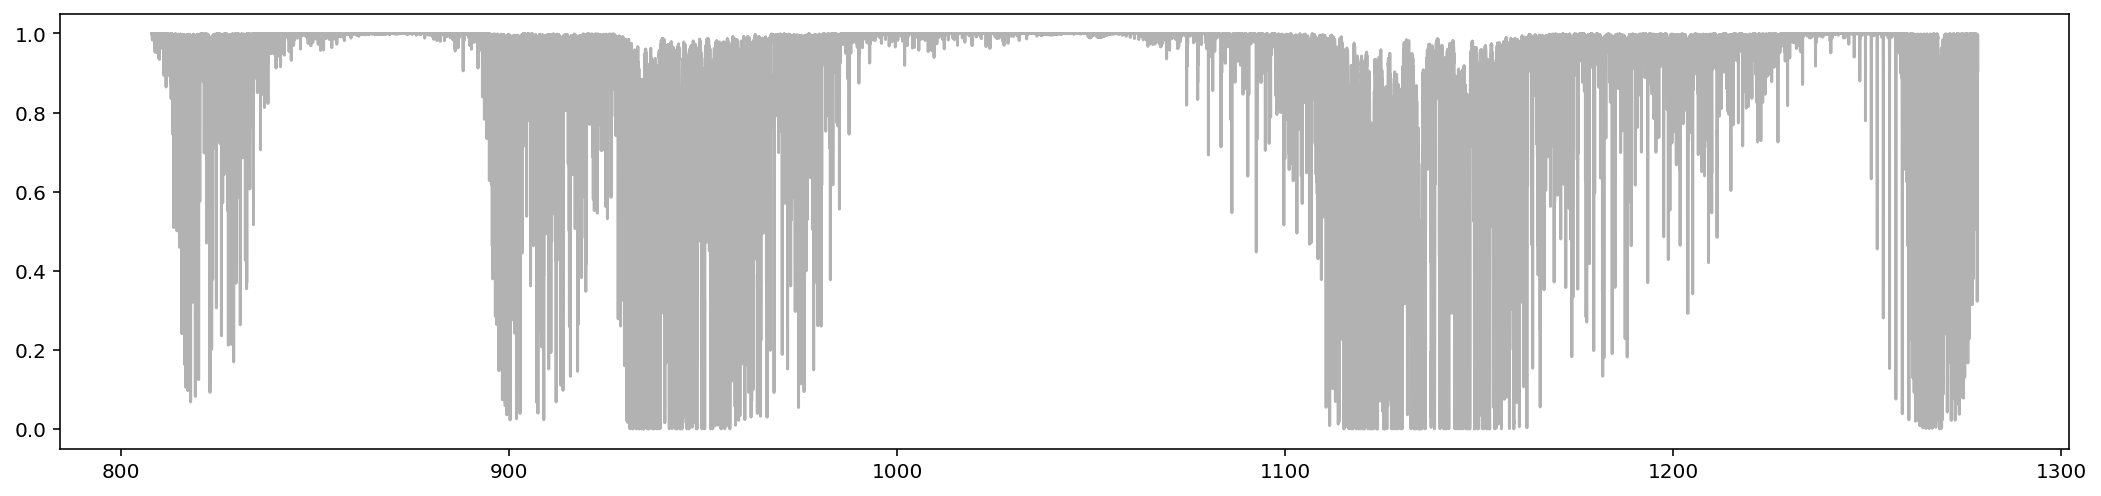

In [30]:
plt.figure(figsize=(18,4))
plt.plot(result.x, result.y, alpha=0.3, color='k');

Ok! We have TelFit working.  Our new GPU framework is next!